In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import random
import numpy as np
import pandas as pd
from scipy.interpolate import interp1d
from scipy.integrate import quad

import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.patheffects

import vice

In [3]:
from surp import ViceModel
from surp import subgiants
import seaborn as sns
import arya
import surp

In [6]:
fiducial = ViceModel.from_saved("../../models/C11_f0.2_RIaexp/model.json")

In [7]:
tracks = pd.read_csv("../out/C11_f0.2_gaussian_dt0.05_gaussian_walks.dat")

In [7]:
s = fiducial.stars_unsampled

In [8]:
filt = s.formation_time < 10
s1 = s[filt]

In [9]:
dt = 13.2 - s1.formation_time
dr = (s1.r_final - s1.r_origin)
slope = dr / dt**0.5

In [10]:
gaus = 

SyntaxError: invalid syntax (1591419579.py, line 1)

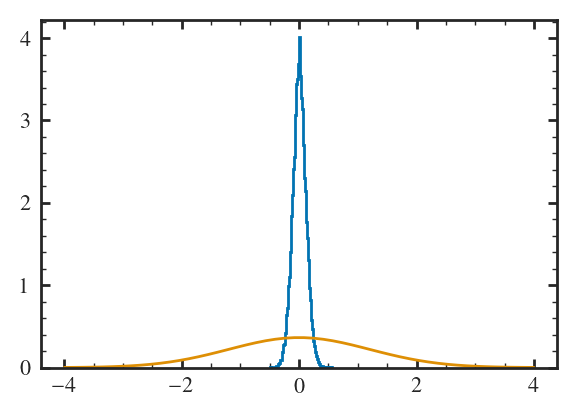

In [11]:
plt.hist(slope, 100, density=True, histtype="step");
x = np.linspace(-4, 4)
sigma = 1.2
y = 1/(2*np.pi*sigma)**0.5 * np.exp(-x**2/(2*sigma**2))
plt.plot(x, y)

In [12]:
plt.scatter(df.formation_time, df.zone_final)

NameError: name 'df' is not defined

In [13]:
df = tracks[tracks.N == 15000]
plt.scatter(df.t, df.R)

NameError: name 'tracks' is not defined

In [14]:
surp.yields.set_yields()

yields set to Magg et al. 2022 abundances
Yield settings
X        Z_solar    CC                             agb                            SN Ia                          

c        3.39e-03   2.28e-03 + 4.40e-02 (Z - Z0)   1.50 × cristallo11             0                              

n        1.04e-03   5.00e-04                       5.02e-04 M Z/Z0                0                              

o        7.33e-03   7.13e-03                       0                              0                              

mg       6.71e-04   6.52e-04                       0                              0                              

fe       1.37e-03   4.73e-04                       0                              7.70e-04                       



total c yield
y0_agb  0.00038
z0_agb  -0.01
agb_model:  cristallo11
0.002850 + 0.029000 (Z-Zo)
f_agb = 0.2000




In [15]:
vice.solar_z("o")/vice.solar_z("mg")

10.923994038748136

In [16]:
vice.yields.ccsne.settings["o"]/vice.yields.ccsne.settings["mg"]

10.93558282208589

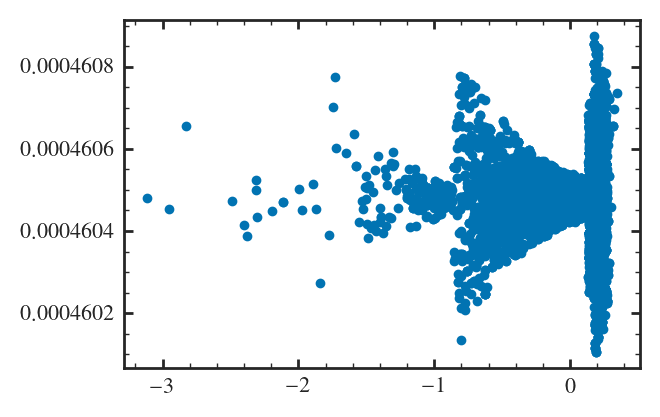

In [17]:
plt.scatter(fiducial.stars.MG_H, fiducial.stars.O_MG)

KeyError: '[o/h]'

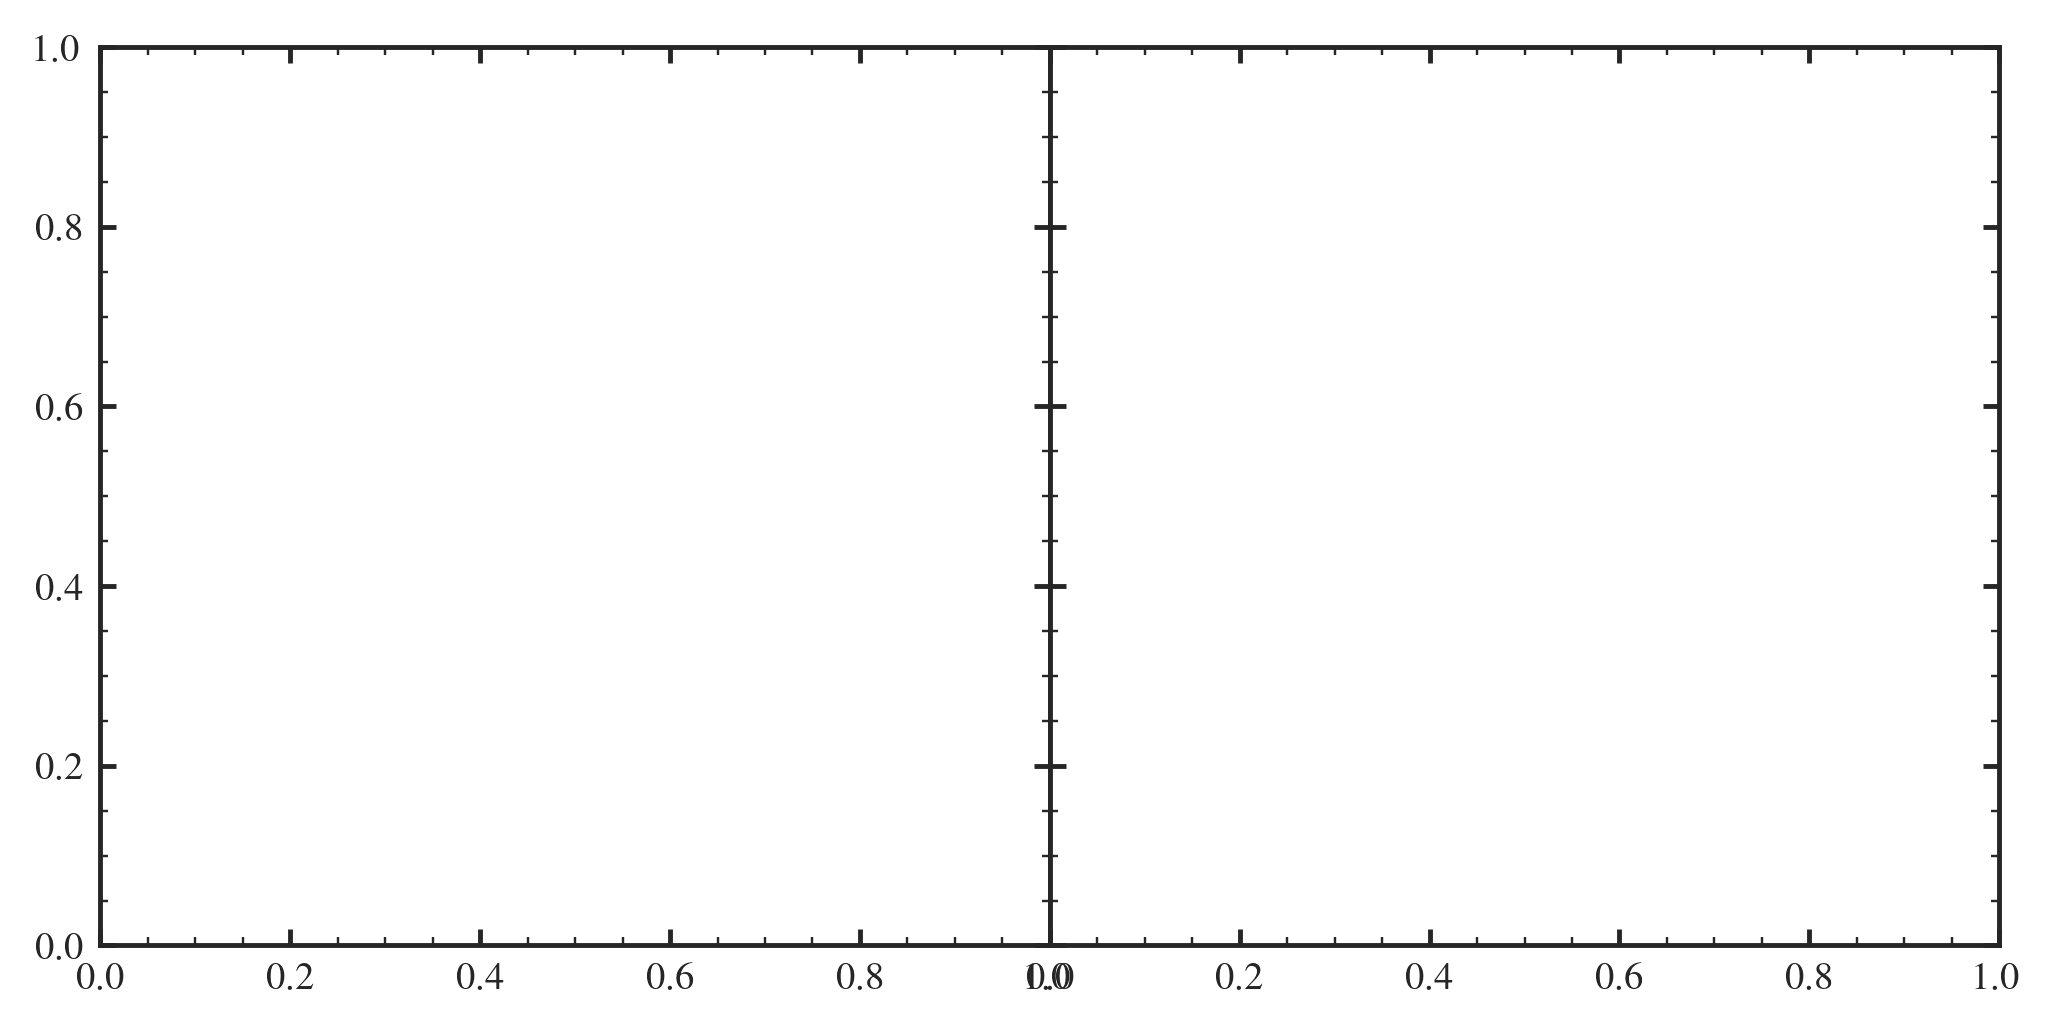

In [18]:
fig, axs = plt.subplots(1, 2, sharey=True, gridspec_kw={"wspace": 0}, figsize=(7, 10/3), dpi=350)

plt.sca(axs[0])
h = fiducial.history

coords = []

for R in [4, 6, 8, 10, 12]:
    df = h[np.isclose(h.R, R - 0.05)]
    plt.plot(df["[o/h]"], df["[c/o]"], color="k")
    coords.append((
            df["[o/h]"][-1], 
            df["[c/o]"][-1]
        ))


texts = [
    "4",
    "6",
    "8",
    "10",
    r"12\,kpc"
]

for i in range(len(coords)):
    if i >= 2:
        offset = (-6, 12)
    else:
        offset = (-3, 6)
    text = plt.annotate(texts[i], xy=coords[i],  zorder=20, ha="center", va="bottom",  
                        xycoords='data', textcoords='offset points', xytext=offset)

sns.scatterplot(h[(h.R > 2) & (h.R < 15.5)], x="[o/h]", y="[c/o]", hue="time", s=0.3, alpha=1, legend=False, edgecolor="none", palette="arya_r", rasterized=True)
plt.xlim(-0.8, 0.6)
plt.ylim(-0.4, 0.05)


plt.xlabel("[Mg/H]")
plt.ylabel("[C/Mg]")

plt.sca(axs[1])



filt = fiducial.history["[o/h]"] > -0.15
filt &= fiducial.history["[o/h]"] < -0.05
h = fiducial.history

cax = axs[1].inset_axes([1.05, 0., 0.05, 1])

cb = arya.Colorbar(clim=(0, 13.2), label=r"time (Gyr)", cmap="arya_r", cax=cax)

coords = []

for R in np.sort(h.R.unique()[19:155]):
    dfa = h[h.R == R]
    s = 1# 0*(0.05 - np.abs(dfa["[o/h]"] + 0.10))
    plt.scatter(dfa["[o/fe]"], dfa["[c/o]"], c=cb(dfa.time), s=0.3, ec="none", rasterized=True, zorder=1)
    if any(np.isclose(R+0.05, [4, 6, 8, 10, 12])):
        coords.append((
            dfa["[o/fe]"][-1], 
            dfa["[c/o]"][-1]
        ))

        plt.plot(dfa["[o/fe]"], dfa["[c/o]"], color="k", zorder=2, lw=1)
    

texts = [
    "4\\,kpc",
    "6",
    "8",
    "10",
    r"12"
]

for i in range(len(coords)):
    text = plt.annotate(texts[i], xy=coords[i],  zorder=20, ha="right",  va="center",
                        xycoords='data', textcoords='offset points', xytext=(-3, 0))
#     text.set_path_effects([mpl.patheffects.Stroke(linewidth=5, foreground='w'),
#                    mpl.patheffects.Normal()])
    
# plt.xlim(-0.05, 0.3)
# plt.ylim(-0.35, 0.05)
plt.xlabel("[Mg/Fe]")



# F AGB
Here, I want to make plots of the AGB Fraction across the galaxy.

In [28]:
def y_cc(Z):
    return surp.yields.C_CC_model(zeta=0.09, y0=0.004)(Z)

In [29]:
h = fiducial.history
m_star = h["sfr"]*1e9 # Msun/yr (default)
denom = 1 + h["eta_0"] - h["r_eff"]
Zc = h["z(c)"]
Mc = h["mass(c)"] # Msun
dt = h.time.unique()[1] # Gyr

smooth = 10
Mc_dot = np.concatenate([np.zeros(smooth), 
                         Mc[smooth:] - np.array(Mc[:-smooth]),
                        ]
                       )/(smooth*dt)
Z = h["z"]

yc_cc = y_cc(Z)
y_c = (Mc_dot + denom*Zc*m_star)/m_star
y_c_agb = y_c - yc_cc
f_agb = np.array(y_c_agb/y_c)

X = np.reshape(f_agb, (200, -1))

In [9]:
max(f_agb[f_agb < 0.5])

0.14888180221553168

(-1.0, 1.0)

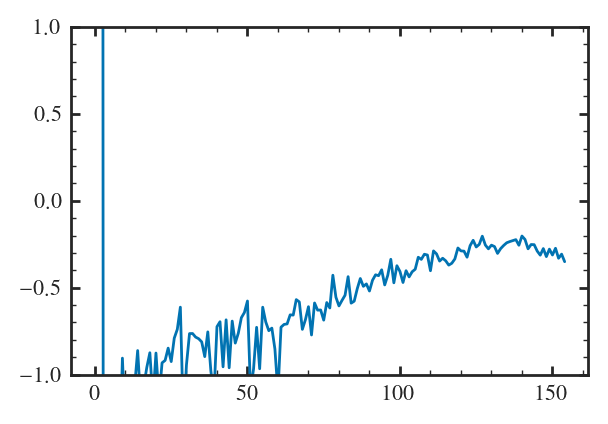

In [10]:
plt.plot(np.transpose(X)[-1,:])
plt.ylim(-1, 1)

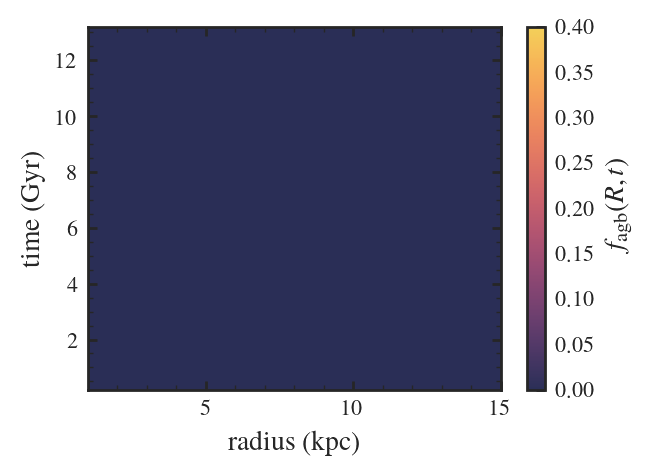

In [11]:
plt.figure(figsize=(10/3, 10/3/np.sqrt(2)))
plt.imshow(np.transpose(X)[::-1], clim=(0, 0.4), extent=(0, 20, 0, 13.2), aspect="auto")
plt.xlim(1, 15)
plt.ylim(smooth*dt)

plt.colorbar(label=r"$f_{\rm agb}(R, t)$")
plt.xlabel("radius (kpc)")
plt.ylabel("time (Gyr)")

plt.savefig("figures/f_agb_rt.pdf")

# Checking the MDFs

Text(0.5, 0, '[Mg/Fe]')

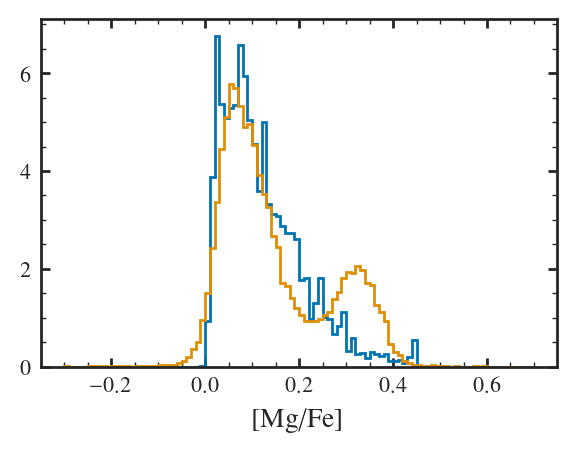

In [71]:
df = fiducial.stars

plt.hist(df["[o/fe]"], 100, histtype="step", density=True, range=(-0.3, 0.7))
plt.hist(subgiants["MG_FE"], 100, histtype="step", density=True, range=(-0.3, 0.7));
plt.xlabel("[Mg/Fe]")

(array([ 669.,  658.,  832.,  711.,  838., 1140., 1093., 1190., 1131.,
        1215., 1226.,  892.,  405.]),
 array([ 0.        ,  1.00769231,  2.01538462,  3.02307692,  4.03076923,
         5.03846154,  6.04615385,  7.05384615,  8.06153846,  9.06923077,
        10.07692308, 11.08461538, 12.09230769, 13.1       ]),
 <BarContainer object of 13 artists>)

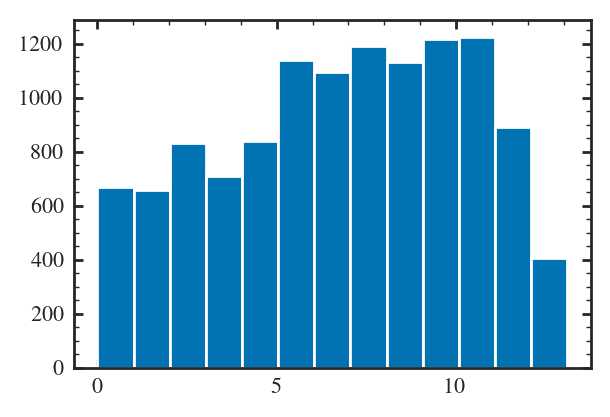

In [72]:
plt.hist(df["age"], 13)

Text(0.5, 0, '[C/Mg]')

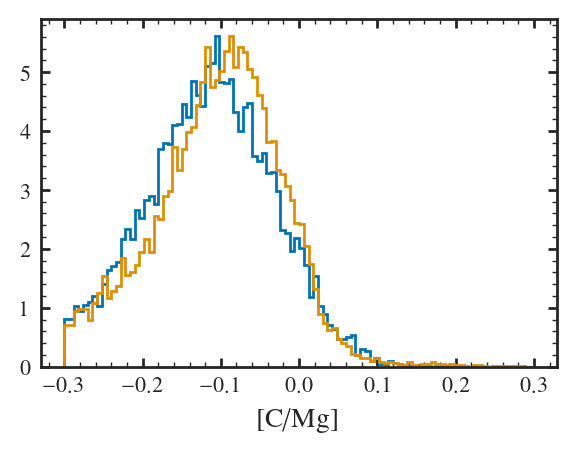

In [73]:
df = fiducial.stars

plt.hist(df["[c/o]"] + np.random.normal(0, 0.07, len(df)), 100, histtype="step", density=True, range=(-0.3, 0.3))
plt.hist(subgiants["C_MG"], 100, histtype="step", density=True, range=(-0.3, 0.3));
plt.xlabel("[C/Mg]")

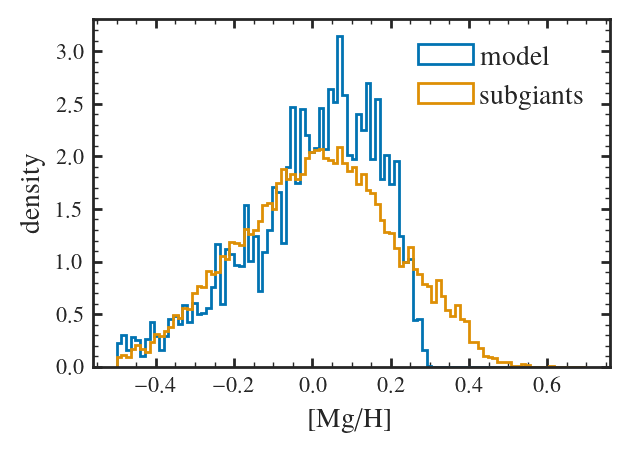

In [74]:
df = fiducial.stars

plt.hist(df["[mg/h]"] + np.random.normal(0, 0.0, len(df)), 100, histtype="step", density=True, range=(-0.5, 0.7), label="model")
plt.hist(subgiants["MG_H"], 100, histtype="step", density=True, range=(-0.5, 0.7), label="subgiants");
plt.xlabel("[Mg/H]")
plt.ylabel("density")
plt.legend()
plt.savefig("mdf.pdf")

Text(0.5, 0, '[O/H]')

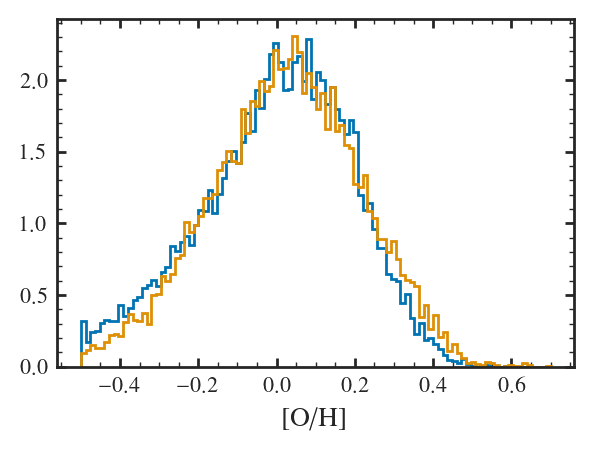

In [75]:
df = fiducial.stars

plt.hist(df["[o/h]"] + np.random.normal(0, 0.1, len(df)), 100, histtype="step", density=True, range=(-0.5, 0.7))
plt.hist(subgiants["O_H"], 100, histtype="step", density=True, range=(-0.5, 0.7));
plt.xlabel("[O/H]")

Text(0.5, 0, '[Fe/H]')

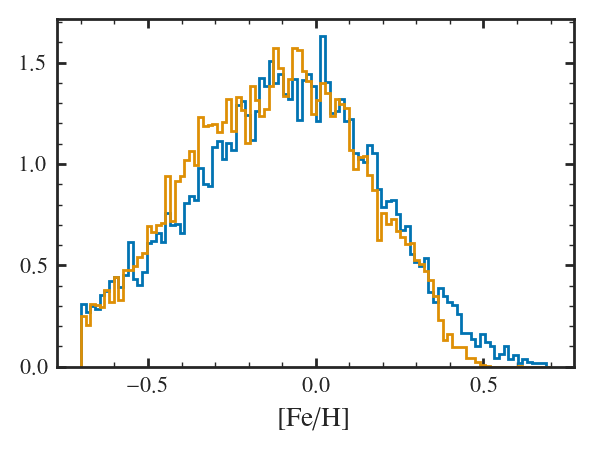

In [76]:
df = fiducial.stars

plt.hist(df["[fe/h]"] + np.random.normal(0, 0.2, len(df)), 100, histtype="step", density=True, range=(-0.7, 0.7))
plt.hist(subgiants["FE_H"], 100, histtype="step", density=True, range=(-0.7, 0.7));
plt.xlabel("[Fe/H]")

(0.0, 1.0)

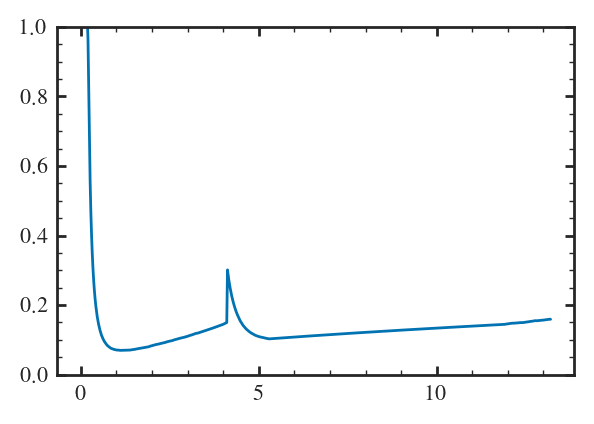

In [9]:
ino = surp.simulation.models.insideout.timescale

h = fiducial.history[np.isclose(fiducial.history.R, 7.05)]
tau_star = h.mgas / h.sfr / 1e9
plt.plot(h.time, tau_star/[ino(r) for r in h.R])
plt.ylim(0, 1)

Text(0, 0.5, 'sfr')

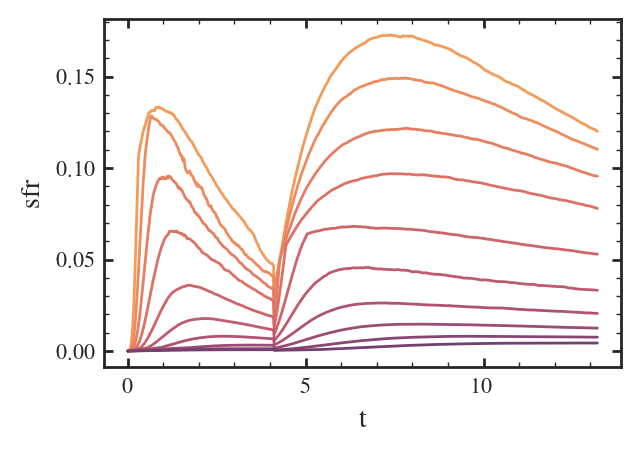

In [7]:
hmap = arya.figure.colorbar.HueMap((0, 15.5), cmap="arya_r")
for R in (np.arange(3, 13, 1) + 0.05):
    h = fiducial.history[np.isclose(fiducial.history.R, R)]
    tau_star = h.sfr
    plt.plot(h.time, tau_star, color=hmap(R))

plt.xlabel("t")
plt.ylabel("sfr")

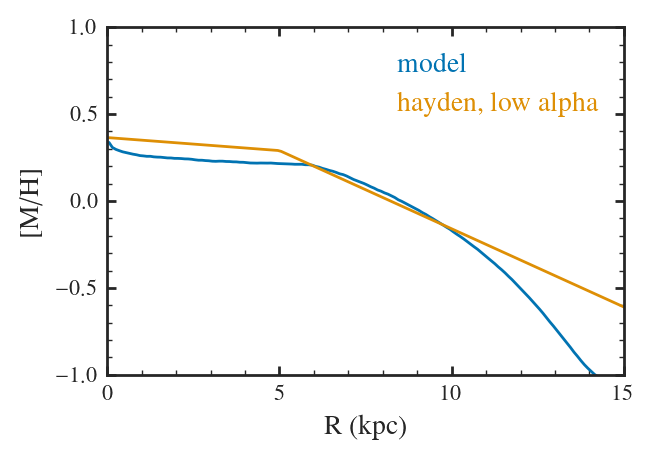

In [25]:
h = fiducial.history[fiducial.history.time == 13]
plt.xlim(0, 15)
plt.plot(h.R, h["[mg/h]"], label="model")
plt.ylim(-1, 1)

x = h.R

plt.plot(x, surp.simulation.multizone_sim.MH_grad(x), label="hayden, low alpha")
plt.xlabel("R (kpc)")
plt.ylabel("[M/H]")

# arya.medianplot(giants[~giants.high_alpha], "R_gal", "MG_H", binsize=500, stat="median", errorbar='pi', label="giants, low alpha")
# arya.medianplot(fiducial.stars, "r_final", "MG_H", binsize=500, stat="median", errorbar='pi')

arya.Legend(color_only=True)
plt.savefig("M_H.pdf")

Text(0, 0.5, 'eta')

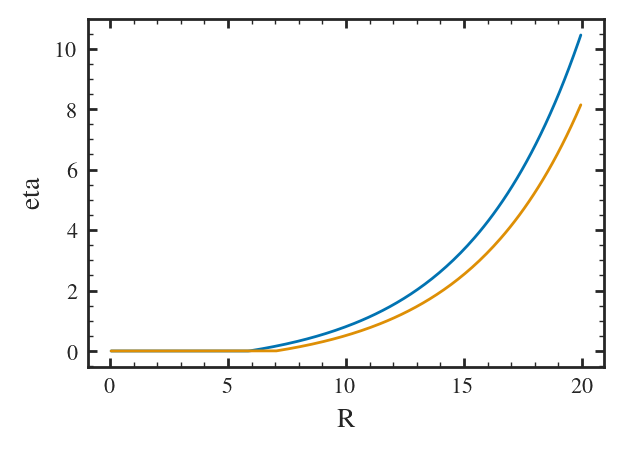

In [26]:
plt.plot(h.R, h.eta_0)
eta = surp.simulation.multizone_sim.mass_loading(tau_s_sf=0)
plt.plot(h.R, eta(h.R))
plt.xlabel("R")
plt.ylabel("eta")

In [29]:
df = fiducial.stars_unsampled

num = 10_000
idx = random.choices(np.arange(len(df)), weights=df["mass"], k=num)

result = {key: np.zeros(num) for key in df.keys()}


for i in range(num):
    for key in df.keys():
        result[key][i] = df[key][idx[i]]
        
result = pd.DataFrame(result)

In [27]:
plt.scatter(result["[o/h]"], result["[c/o]"], s=1)

NameError: name 'result' is not defined

In [30]:
df = giants[~giants["high_alpha"]]

In [35]:
result["[c/h]"] = result["[c/o]"] + result["[o/h]"]
result["[n/h]"] = result["[n/o]"] + result["[o/h]"]

result["[cn/h]"] = np.log10(10**(result["[c/h]"] + 8.39) + 10**(result["[n/h]"] + 7.78)) - np.log10(10**8.39 + 10**7.78)
result["[cn/o]"] = result["[cn/h]"] - result["[o/h]"] + 0.075

In [ ]:
arya.plotting.medianplot(result, x="[o/h]", y="[cn/o]",stat="median", aes="line", binsize=100, errorbar=None, label="model")


arya.plotting.medianplot(df, x="MG_H", y="CN_MG", binsize=200, stat="median", label="APOGEE Giants")
plt.xlabel("[Mg/H]")
plt.ylabel("[C/Mg]")

plt.xlim(-0.65, 0.4)
plt.ylim(-0.2, 0.15)

arya.Legend(color_only=True)
plt.savefig("cpn.pdf")



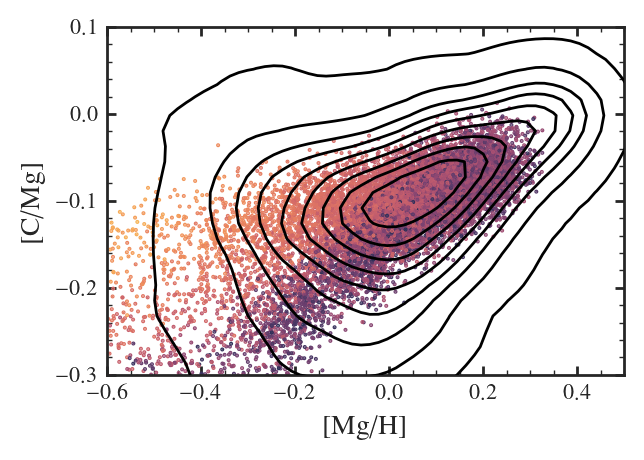

In [77]:
s = fiducial.stars
N = len(s)
dx = 0.025
dy = 0.025
aah.plot_contour("[mg/h]", "[c/mg]", zorder=3, exclude_high_alpha=False)

plt.scatter(s["[mg/h]"] + np.random.normal(0, dx, N), s["[c/mg]"] + np.random.normal(0, dy, N), 
             c = s["r_origin"], s=0.2, zorder=2)
plt.xlim(-0.6, 0.5)
plt.ylim(-0.3, 0.1)
plt.xlabel("[Mg/H]")
plt.ylabel("[C/Mg]")

plt.savefig("figures/fiducial_scatter.pdf")

In [21]:
s = fiducial.stars
N = len(s)
dx = 0.025
dy = 0.025
surp.plots.plot_contour("[fe/h]", "[mg/fe]", zorder=3, exclude_high_alpha=False)

plt.scatter(s["[fe/h]"] + np.random.normal(0, dx, N), s["[mg/fe]"] + np.random.normal(0, dy, N), 
             c = s["r_origin"], s=0.03, zorder=2)


plt.xlim(-1, 0.5)
plt.ylim(-0.1, 0.5)
plt.xlabel("[Fe/H]")
plt.ylabel("[Mg/Fe]")


AttributeError: module 'surp.plots' has no attribute 'plot_contour'

Text(0, 0.5, '[N/Mg]')

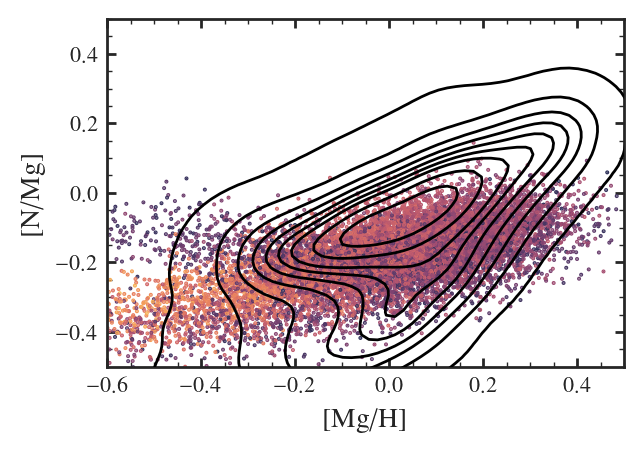

In [18]:
s = fiducial.stars
N = len(s)
dx = 0.09
dy = 0.05
aah.plot_contour("[mg/h]", "[n/mg]", zorder=3, exclude_high_alpha=False)

plt.scatter(s["[mg/h]"] + np.random.normal(0, dx, N), s["[n/mg]"] + np.random.normal(0, dy, N), 
             c = s["r_origin"], s=0.2, zorder=2)
plt.xlim(-0.6, 0.5)
plt.ylim(-0.5, 0.5)
plt.xlabel("[Mg/H]")
plt.ylabel("[N/Mg]")


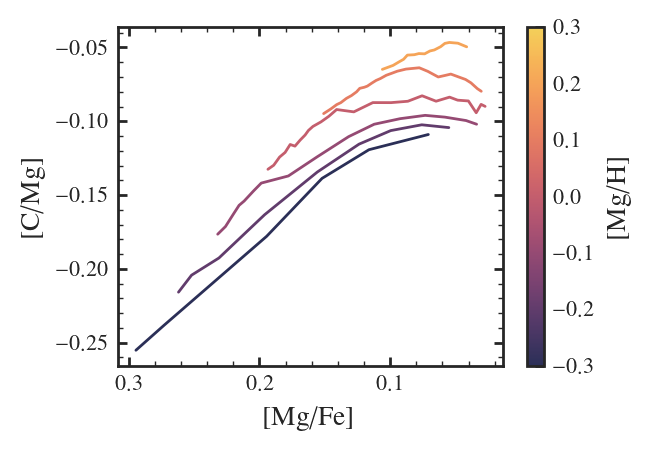

In [30]:
plt.figure(figsize=(10/3, 10/3/2**0.5))

cb = arya.Colorbar(clim=(-0.3, 0.3), label="[Mg/H]")

s = fiducial.stars
for MH in (-0.3, -0.2,-0.1,0, 0.1, 0.2,0.3):
    mh0 = MH - 0.05
    mh1 = MH + 0.05
    filt = s["[o/h]"] > mh0
    filt &= s["[o/h]"] < mh1
    df = s[filt]
    
    arya.medianplot(df, x="[o/fe]", y="[c/o]", binsize=100, color=cb(MH), aes="line", errorbar=None)

plt.gca().invert_xaxis()

plt.xlabel("[Mg/Fe]")
plt.ylabel("[C/Mg]")

plt.tight_layout()
plt.savefig("figures/fiducial_caafe_binned.pdf")

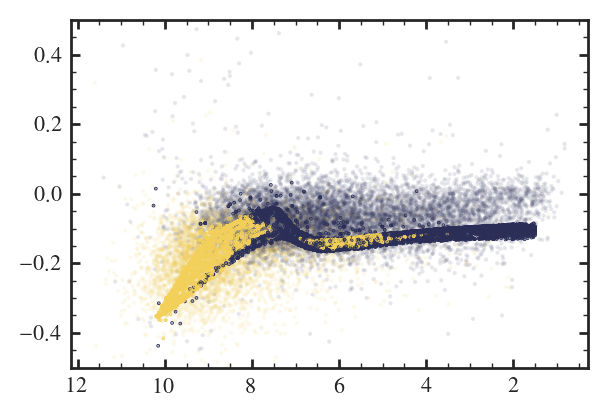

In [21]:
plt.scatter(subgiants.age, subgiants.C_MG, c=subgiants.high_alpha, s=0.3, alpha=0.1)
plt.gca().invert_xaxis()
plt.ylim(-0.5, 0.5)

plt.scatter(fiducial.stars.age/1.5 + 1.5, fiducial.stars["[c/mg]"], c=fiducial.stars.high_alpha, s=0.1)

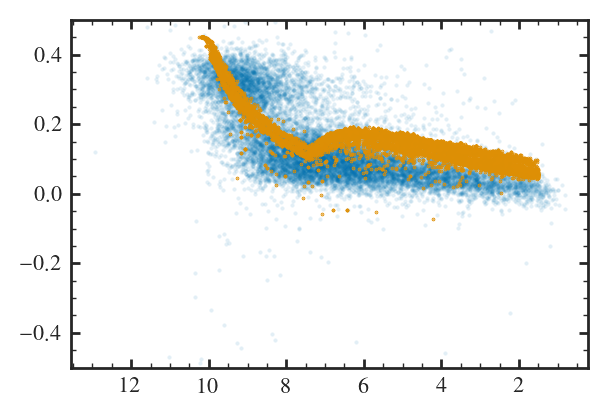

In [22]:
plt.scatter(subgiants.age, subgiants.MG_FE, s=0.3, alpha=0.1)
plt.gca().invert_xaxis()
plt.ylim(-0.5, 0.5)

plt.scatter(fiducial.stars.age/1.5 + 1.5, fiducial.stars["[mg/fe]"], s=0.1)
plt.ylim()